In [14]:
import sys
# import from dirs below
sys.path.insert(0, "..")
sys.path.insert(0, "../src")
sys.path.insert(0, "../src/new_generation")

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from typing import List, Tuple
import random

from copy import deepcopy
import networkx as nx

import line_generation as lg
from Genotype import Genotype
from fitness import fitness
from params import N, SEED, N_IN_POPULATION
from graph_generation import generate_city_graph
from SimultionEngine import SimulationEngine

from main import create_initial_population, n_best_survive, new_generation_replace_random_line

from new_generation.Mutators import LineMutator, GenotypeMutator
from new_generation.SpecimenCrossers import GenotypeCrosser

In [18]:
from SimultionEngine import SimulationEngine

In [19]:
G, best_paths = generate_city_graph(N)

line_mutator = LineMutator(best_paths)
genotype_mutator = GenotypeMutator(G, best_paths)

genotype_crosser = GenotypeCrosser(best_paths)

## Mutacje linii

5
Population 0, fitness function: -218.99966871782752
lines with X stops: Counter({10: 200})


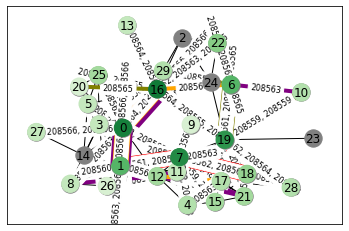

5
Population 1, fitness function: -218.99966871782752
lines with X stops: Counter({10: 200})


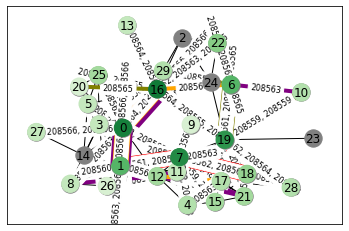

5
Population 2, fitness function: -218.99966871782752
lines with X stops: Counter({10: 200})


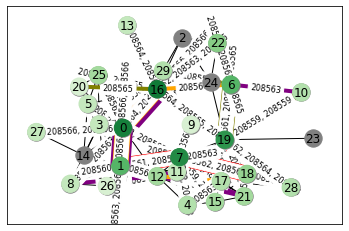

5
Population 3, fitness function: -218.99966871782752
lines with X stops: Counter({10: 200})


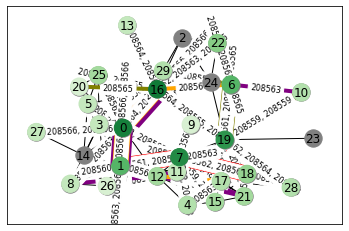

5
Population 4, fitness function: -218.9909838270255
lines with X stops: Counter({10: 200})


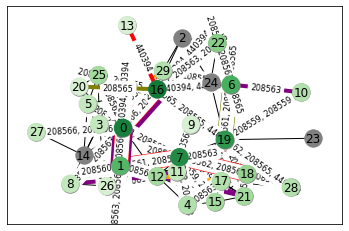

5
Population 5, fitness function: -218.84620347773642
lines with X stops: Counter({10: 200})


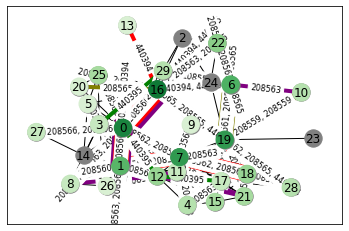

5
Population 6, fitness function: -211.8242841027444
lines with X stops: Counter({10: 200})


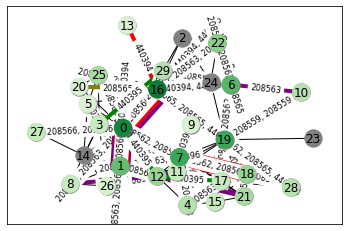

2
Population 7, fitness function: -211.8242841027444
lines with X stops: Counter({10: 200})


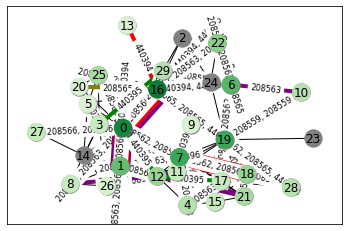

5
Population 8, fitness function: -209.17920804054782
lines with X stops: Counter({10: 200})


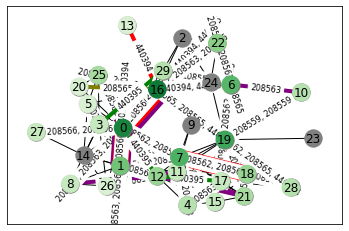

5
Population 9, fitness function: -209.17920804054782
lines with X stops: Counter({10: 200})


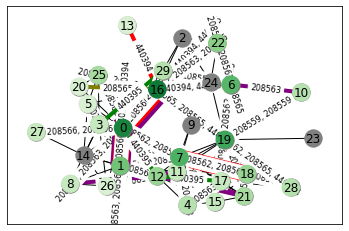

5
Population 10, fitness function: -209.17920804054782
lines with X stops: Counter({10: 200})


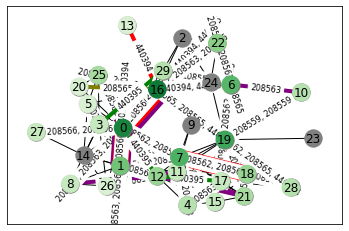

In [55]:
def new_generation(
    population_with_fitness: List[Tuple[Genotype, float]],
    G: nx.Graph,
    new_generation_size: int,
    best_paths,
) -> List[Genotype]:
    
    
    # extract organisms only (ignore fitness) from population_with_fitness
    new_generation: List[Genotype] = [
        organism_with_fitness[0] for organism_with_fitness in population_with_fitness
    ]

    counter = 0
    while len(new_generation) < new_generation_size:
        # get organism (clone it, don't modify original) by
        # looping over population_with_fitness with counter index
        organism: Genotype = deepcopy(
            population_with_fitness[counter % len(population_with_fitness)][0]
        )

        # (operating on clone)
        # get random line, remove it
        # run line mutator on it
        # add it back
        #random_line = random.sample(organism.lines, 1)[0]
        #organism.lines.remove(random_line)
        #new_line = line_mutator.invert(random_line)
        #organism.lines.append(new_line)
        
        # run genotype mutator
        #organism = genotype_mutator.split_line(organism) # using GenotypeMutator(G, best_paths) also doesn't work
        #organism = genotype_mutator.merge_lines(organism)
        
        # add clone to new generation
        new_generation.append(organism)

        counter += 1

    return new_generation





sim_engine = SimulationEngine(
    G,
    initial_population=create_initial_population(G, best_paths),
    fitness_function=fitness,
    survival_function=lambda population: n_best_survive(
        population, N_IN_POPULATION - 1 # TODO return back to // 5
    ),
    new_generation_function=lambda population, graph: new_generation(
        population, graph, N_IN_POPULATION, best_paths
    ),
)

sim_engine.run(10, 1, report_show=True)